### 介绍 \ Introduction

这一节主要介绍如何使用FLGo来实现自己的idea。这里首先关注的是本地训练阶段有所变化的算法（如FedProx，MOON等），这类算法在联邦学习中是极为常见的，因为联邦学习中用户数据分布通常是non-IID的，导致本地训练容易越走越偏。下面从FedProx入手，讲解如何使用FLGo复现该算法。

### FedProx简介 

FedProx是Li Tian等人于2018年([论文链接](https://arxiv.org/abs/1812.06127))所提出的一种针对系统异构性鲁棒的联邦优化算法，发表于MLSys 2020上。它相较于FedAvg主要做出了两点改进：

1. 采样阶段
使用了按数据集大小比例，可放回采样，并直接平均聚合（无加权）来获得无偏梯度估计

2. 本地训练阶段
基于近端项优化的思路，魔改了本地训练的目标函数为 $L+\frac{\mu}{2}\|w_{k,i}^{t}-w_{global}\|_{2}$

由于该采样方式已被FLGo集成并默认使用，要实现FedProx只需要修改本地训练阶段的代码


### 加入算法超参数
所有的横向联邦中的超参数都在Server的initialize方法中加入，加入的方法是调用Server.init_algo_para方法，并传入超参数字典。例如，对于fedprox来说，超参数是mu，因此只要通过该方法传入{'mu':0.01}，Server和Client就会被添加额外的属性Server.mu和Client.mu来访问该超参数，其中0.01是默认值。

In [1]:
import flgo.algorithm.fedbase as fedbase
import flgo.algorithm.fedavg as fedavg
import flgo.utils.fmodule as fmodule
import os
import flgo
import copy
import torch

class Server(fedbase.BasicServer):
    def initialize(self, *args, **kwargs):
        self.init_algo_para({'mu':0.01})

### 修改本地训练阶段

In [2]:
class Client(fedbase.BasicClient):
    @fmodule.with_multi_gpus
    def train(self, model):
        # 记录全局模型参数\global parameters
        src_model = copy.deepcopy(model)
        # 冻结全局模型梯度
        src_model.freeze_grad()
        model.train()
        optimizer = self.calculator.get_optimizer(model, lr=self.learning_rate, weight_decay=self.weight_decay, momentum=self.momentum)
        for iter in range(self.num_steps):
            # get a batch of data
            batch_data = self.get_batch_data()
            model.zero_grad()
            # calculate the loss of the model on batched dataset through task-specified calculator
            loss = self.calculator.compute_loss(model, batch_data)['loss']
            # 计算近端项损失
            loss_proximal = 0
            for pm, ps in zip(model.parameters(), src_model.parameters()):
                loss_proximal += torch.sum(torch.pow(pm - ps, 2))
            loss = loss + 0.5 * self.mu * loss_proximal
            loss.backward()
            optimizer.step()
        return

### 构造算法fedprox
在FLGo中，每个算法既可以用一个类表示，也可以用一个文件表示，唯一的要求是算法必须具备 algorithm_name.Server和algorithm_name.Client这两个属性（对于横向联邦是这俩）。

In [3]:
class fedprox:
    Server = Server
    Client = Client

### 测试fedprox

2023-03-11 02:04:34,979 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.
2023-03-11 02:04:37,165 fflow.py init [line:384] INFO Use `<class 'flgo.system_simulator.default_simulator.Simulator'>` as the system simulator
2023-03-11 02:04:37,170 fflow.py init [line:392] INFO Ready to start.
2023-03-11 02:04:37,177 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.
2023-03-11 02:04:37,362 fflow.py init [line:384] INFO Use `<class 'flgo.system_simulator.default_simulator.Simulator'>` as the system simulator
2023-03-11 02:04:37,362 fflow.py init [line:392] INFO Ready to start.
2023-03-11 02:04:37,369 fedbase.py run [line:102] INFO --------------Initial Evaluation--------------
2023-03-11 02:04:37,369 simple_logger.py log_once [line:13] INFO Current_time:0
2023-03-11 02:04:37,850 simple_logger.py log_once [line:27] INFO test_accuracy                 0.0489
2023-03-11 02:04:37,850 simple_logger.py log_once [line:27] 

2023-03-11 02:04:38,665 fedbase.py run [line:112] INFO --------------Round 7--------------
2023-03-11 02:04:38,665 simple_logger.py log_once [line:13] INFO Current_time:7
2023-03-11 02:04:38,687 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5878
2023-03-11 02:04:38,687 simple_logger.py log_once [line:27] INFO test_loss                     1.9630
2023-03-11 02:04:38,687 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5922
2023-03-11 02:04:38,688 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5922
2023-03-11 02:04:38,688 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3973
2023-03-11 02:04:38,688 simple_logger.py log_once [line:27] INFO valid_loss                    1.9363
2023-03-11 02:04:38,689 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.9363
2023-03-11 02:04:38,689 simple_logger.py log_once [line:27] INFO std_valid_loss                2.2826
2023-03-11 02

2023-03-11 02:04:39,472 simple_logger.py log_once [line:27] INFO valid_loss                    1.1582
2023-03-11 02:04:39,472 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1582
2023-03-11 02:04:39,472 simple_logger.py log_once [line:27] INFO std_valid_loss                1.3062
2023-03-11 02:04:39,472 fedbase.py run [line:117] INFO Eval Time Cost:               0.0227s
2023-03-11 02:04:39,537 fedbase.py run [line:112] INFO --------------Round 15--------------
2023-03-11 02:04:39,537 simple_logger.py log_once [line:13] INFO Current_time:15
2023-03-11 02:04:39,558 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6872
2023-03-11 02:04:39,558 simple_logger.py log_once [line:27] INFO test_loss                     1.4446
2023-03-11 02:04:39,558 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6843
2023-03-11 02:04:39,559 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6843
2023-03-11 02:04:39,

2023-03-11 02:04:40,336 simple_logger.py log_once [line:27] INFO test_loss                     1.0859
2023-03-11 02:04:40,336 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7333
2023-03-11 02:04:40,336 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7333
2023-03-11 02:04:40,336 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3199
2023-03-11 02:04:40,337 simple_logger.py log_once [line:27] INFO valid_loss                    1.0721
2023-03-11 02:04:40,337 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0721
2023-03-11 02:04:40,337 simple_logger.py log_once [line:27] INFO std_valid_loss                1.4704
2023-03-11 02:04:40,337 fedbase.py run [line:117] INFO Eval Time Cost:               0.0225s
2023-03-11 02:04:40,425 fedbase.py run [line:112] INFO --------------Round 23--------------
2023-03-11 02:04:40,425 simple_logger.py log_once [line:13] INFO Current_time:23
2023-03-11 02:04:40,

2023-03-11 02:04:41,177 fedbase.py run [line:117] INFO Eval Time Cost:               0.0636s
2023-03-11 02:04:41,275 fedbase.py run [line:112] INFO --------------Round 30--------------
2023-03-11 02:04:41,276 simple_logger.py log_once [line:13] INFO Current_time:30
2023-03-11 02:04:41,296 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7378
2023-03-11 02:04:41,296 simple_logger.py log_once [line:27] INFO test_loss                     1.0928
2023-03-11 02:04:41,297 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7637
2023-03-11 02:04:41,297 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7637
2023-03-11 02:04:41,297 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2609
2023-03-11 02:04:41,298 simple_logger.py log_once [line:27] INFO valid_loss                    1.0441
2023-03-11 02:04:41,298 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.0441
2023-03-11 02:04:41,

2023-03-11 02:04:42,301 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5794
2023-03-11 02:04:42,301 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5794
2023-03-11 02:04:42,302 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.4052
2023-03-11 02:04:42,302 simple_logger.py log_once [line:27] INFO valid_loss                    2.0528
2023-03-11 02:04:42,302 simple_logger.py log_once [line:27] INFO mean_valid_loss               2.0528
2023-03-11 02:04:42,302 simple_logger.py log_once [line:27] INFO std_valid_loss                2.3176
2023-03-11 02:04:42,303 fedbase.py run [line:117] INFO Eval Time Cost:               0.0235s
2023-03-11 02:04:42,461 fedbase.py run [line:112] INFO --------------Round 7--------------
2023-03-11 02:04:42,461 simple_logger.py log_once [line:13] INFO Current_time:7
2023-03-11 02:04:42,482 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6011
2023-03-11 02:04:42,48

2023-03-11 02:04:43,688 fedbase.py run [line:112] INFO --------------Round 14--------------
2023-03-11 02:04:43,688 simple_logger.py log_once [line:13] INFO Current_time:14
2023-03-11 02:04:43,709 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6550
2023-03-11 02:04:43,709 simple_logger.py log_once [line:27] INFO test_loss                     1.3782
2023-03-11 02:04:43,710 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6539
2023-03-11 02:04:43,710 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6539
2023-03-11 02:04:43,710 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3620
2023-03-11 02:04:43,710 simple_logger.py log_once [line:27] INFO valid_loss                    1.3336
2023-03-11 02:04:43,711 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.3336
2023-03-11 02:04:43,711 simple_logger.py log_once [line:27] INFO std_valid_loss                1.5275
2023-03-11 

2023-03-11 02:04:45,005 simple_logger.py log_once [line:27] INFO valid_loss                    1.1870
2023-03-11 02:04:45,005 simple_logger.py log_once [line:27] INFO mean_valid_loss               1.1870
2023-03-11 02:04:45,005 simple_logger.py log_once [line:27] INFO std_valid_loss                1.5852
2023-03-11 02:04:45,005 fedbase.py run [line:117] INFO Eval Time Cost:               0.0223s
2023-03-11 02:04:45,165 fedbase.py run [line:112] INFO --------------Round 22--------------
2023-03-11 02:04:45,165 simple_logger.py log_once [line:13] INFO Current_time:22
2023-03-11 02:04:45,185 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6733
2023-03-11 02:04:45,186 simple_logger.py log_once [line:27] INFO test_loss                     1.1621
2023-03-11 02:04:45,186 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6706
2023-03-11 02:04:45,186 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6706
2023-03-11 02:04:45,

2023-03-11 02:04:46,335 simple_logger.py log_once [line:27] INFO test_loss                     0.8083
2023-03-11 02:04:46,335 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8039
2023-03-11 02:04:46,335 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8039
2023-03-11 02:04:46,336 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2324
2023-03-11 02:04:46,336 simple_logger.py log_once [line:27] INFO valid_loss                    0.6969
2023-03-11 02:04:46,336 simple_logger.py log_once [line:27] INFO mean_valid_loss               0.6969
2023-03-11 02:04:46,336 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0325
2023-03-11 02:04:46,337 fedbase.py run [line:117] INFO Eval Time Cost:               0.0231s
2023-03-11 02:04:46,502 fedbase.py run [line:112] INFO --------------Round 30--------------
2023-03-11 02:04:46,502 simple_logger.py log_once [line:13] INFO Current_time:30
2023-03-11 02:04:46,

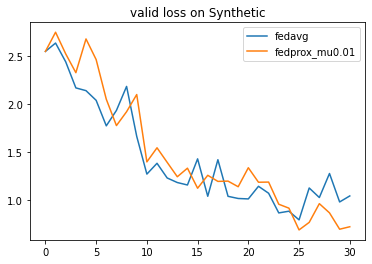

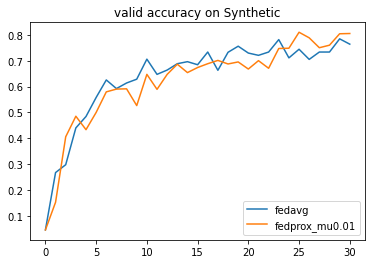

In [4]:
task = './test_synthetic'
config = {'benchmark':{'name':'flgo.benchmark.synthetic_regression', 'para':{'alpha':0.5, 'beta':0.5, 'num_clients':30}}}
if not os.path.exists(task): flgo.gen_task(config, task_path = task)
option = {'num_rounds':30, 'num_epochs':1, 'batch_size':8, 'learning_rate':0.1, 'gpu':0}
fedavg_runner = flgo.init(task, fedavg, option=option)
fedprox_runner = flgo.init(task, fedprox, option=option)
fedavg_runner.run()
fedprox_runner.run()
import flgo.experiment.analyzer
analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg', 'fedprox']
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'valid_loss'}, 'fig_option':{'title':'valid loss on Synthetic'}},
            {'args':{'x': 'communication_round', 'y':'valid_accuracy'},  'fig_option':{'title':'valid accuracy on Synthetic'}},
        ]
    }
}
flgo.experiment.analyzer.show(analysis_plan)